In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt




# import os 
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# use shift+tab to open documentation

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
# using tensorflow image dataset as it can take whole image folder
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
);

Found 2152 files belonging to 3 classes.


# EXTRACT THE CLASS NAME 


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)
# it is in batches thats why it is in 68, do it 68 x 32 it will give u nearly total files

68

### Printing 1 batch

HERE WE CONVERT THE BATCH TO NUMPY AS THEY ARE IN TENSORS



0,1,2 ARE THE THREE CLASSES THAT ARE GIVEN NUMBERED

**Documentation for image and label batch** - https://www.tensorflow.org/tutorials/load_data/images

In [6]:
for image_batch, label_batch in dataset.take(1): # taking 1 data batch
    print('For whole batch - ',image_batch.shape)
    print("For single image -",image_batch[0].shape)
    print('For label batch - ',label_batch.shape)
    print(label_batch.numpy())

For whole batch -  (32, 256, 256, 3)
For single image - (256, 256, 3)
For label batch -  (32,)
[0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 1]


### Printing the image

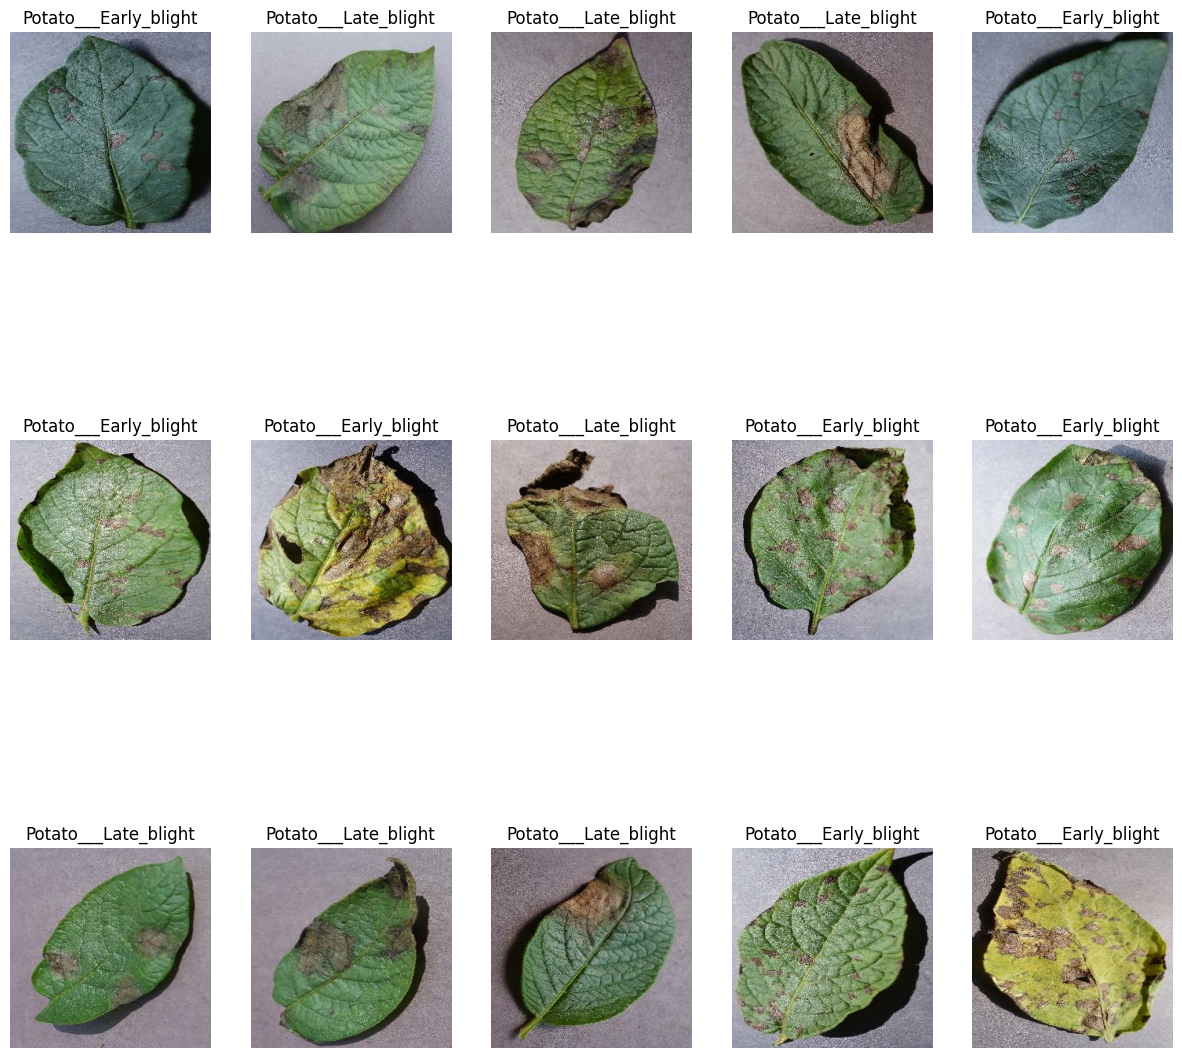

In [7]:
plt.figure(figsize=(15,15))
for i in range(15):
    ax=plt.subplot(3,5,i+1)
    
    plt.imshow(image_batch[i].numpy().astype("uint8"));
    plt.axis("off"); # to remove the axis/graph
    plt.title(class_names[label_batch[i]]);

## Splitting

80% = training

10% = validation

10% = testing


# Here we are going to do train_test_split

In [8]:
train_size=0.8
len(dataset)*0.8

54.400000000000006

In [9]:
train_ds= dataset.take(54) # it just like first 54
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54) # its like after 54
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*0.1

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

### Let's create the function for train test valid

In [14]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds


In [15]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [16]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

# Cacheing

It will read the image from iteration and when you need the image next iteration, 
this will keep image in memory, helps in pipeline for better performance

# Prefetch

when your cpu and gpu are busy training, prefetch will load next set of batch from the disk it will better your perfomance



In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale  = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
resize_and_rescale.build(input_shape=(None,256,256,3))

resize_and_rescale.summary()
# rescaling and resizing imp as many coustom image can come in another format

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# we can make single image into many training images by rotating,etc

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
data_augmentation.build(input_shape=(None,256,256,3))

data_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Make the model

CONV2D LAYER- IT CONTAIN FILTER WHICH TELL HOW MANY WE NEED FOR THE OBJECT TO GET LEARN 

FOREX- IN LEARNING AND CLASSIFICATIONN OF DOG - 1 FILTER FOR NOSE,2FILTER FOR EYES,2 FILTER FOR NOSE

In [20]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Create a Sequential model
# model = Sequential([
# ])
# n_classes = 3

# # Add the layers as per the summary
# # model.add(resize_and_rescale) this line creating problem
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(3, activation='softmax'))

# model.build(input_shape=(256,256,3))
# # Print the model summary
# model.summary()


In [21]:
# after rebuilding data_augmentation and resize_and_rescale into (None,256,256,3) our sequential model is working

# but still if it create problem remove data_augmentation and resize_and_rescale it will work

In [22]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# input_shape=(256,256,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,# this line creating problem as its asking input for 4dim
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 68s 1s/step - loss: 0.9385 - accuracy: 0.5000 - val_loss: 0.8583 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 62s 1s/step - loss: 0.7179 - accuracy: 0.6808 - val_loss: 0.7010 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 59s 1s/step - loss: 0.5239 - accuracy: 0.7741 - val_loss: 0.5081 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 59s 1s/step - loss: 0.3992 - accuracy: 0.8339 - val_loss: 0.3471 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.2607 - accuracy: 0.8885 - val_loss: 0.2170 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 62s 1s/step - loss: 0.2832 - accuracy: 0.8844 - val_loss: 0.3546 - val_accuracy: 0.8490
Epoch 7/50
54/54 [==============================] - 64s 1s/step - loss: 0.3230 - accuracy: 0.8674 - val_loss: 0.4819 - val_accuracy: 0.8073
Epoch 8/50
54/54 [==

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 237ms/step - loss: 0.0697 - accuracy: 0.9648


## Plotting the Accuracy and Loss Curve

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


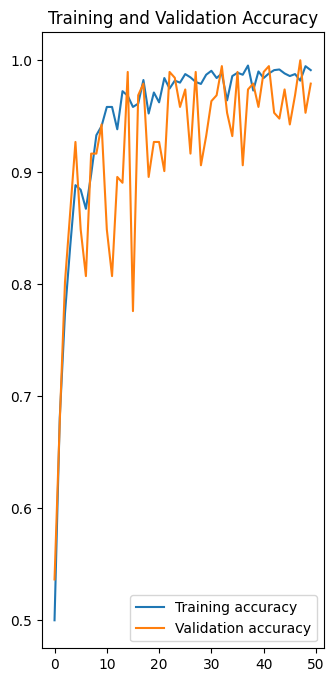

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

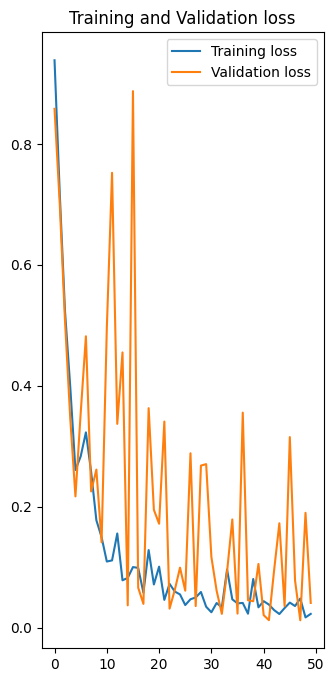

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
plt.show()

# Run predicition on sample image

first image to predict
actual label Potato___healthy
1/1 [==============================] - 1s 825ms/step
predicted label Potato___Early_blight


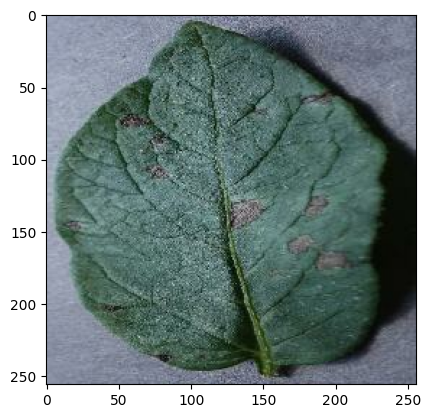

In [33]:
import numpy as np
for image_batches, label_batch  in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label',class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label',class_names[np.argmax(batch_prediction[0])])

# Function for interference

-> `img_array` = tf.keras.preprocessing.image.img_to_array(images[i].numpy())

here it is converting image to array , this is done as ml models sometime take array as input

------------------------------------------------------------

-> `img_array` = tf.expand_dims(img_array, 0)

Here you are adding an extra dimension to the array using tf.expand_dims.
Many machine learning models expect input data to have a batch dimension, even if you're predicting on just one image. Adding this dimension is like saying "I'm giving you one image in a batch."

--------------------------------------------------------------

-> `predicted_class` = class_names[np.argmax(predictions[0])]

Here you're finding the index of the class with the highest prediction value using np.argmax(predictions[0]). This index corresponds to the most likely predicted class.
You then use class_names (which you've defined earlier) to map the index to the actual class name.

------------------------------------------------------------

-> `confidence` = round(100 * (np.max(predictions[0])), 2)

This line calculates the confidence level of the prediction. It finds the maximum prediction value using np.max(predictions[0]), then multiplies it by 100 to convert it into a percentage.
The round function is used to round the confidence value to two decimal places

----------------------------------------------------------------

`np.argmax` and `np.max` are both NumPy functions used for working with arrays, but they serve different purposes:

1. **`np.argmax`:**
   - `np.argmax` stands for "argmax" and is short for "argument of maximum." It returns the index of the maximum value in an array along a specified axis.
   - Syntax: `np.argmax(array, axis=None)`
   - Example:
     ```python
     import numpy as np
     array = np.array([5, 10, 8, 3])
     index_of_max = np.argmax(array)
     print(index_of_max)  # Output: 1 (index of the maximum value, which is 10)
     ```

2. **`np.max`:**
   - `np.max` returns the maximum value in an array along a specified axis.
   - Syntax: `np.max(array, axis=None)`
   - Example:
     ```python
     import numpy as np
     array = np.array([5, 10, 8, 3])
     maximum_value = np.max(array)
     print(maximum_value)  # Output: 10 (maximum value in the array)
     ```

In summary, `np.argmax` returns the index of the maximum value in an array, while `np.max` returns the maximum value itself. You would use `np.argmax` when you want to find the position (index) of the maximum value, and you would use `np.max` when you want to find the actual maximum value in the array.

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])),2)
    return predicted_class, confidence

## Doubts

**In function
def predict predicted_class = class_names[np.argmax(predictions[0])]
why here we take prediction[0] not prediction[i]**

-> In the `predict` function, the line `predicted_class = class_names[np.argmax(predictions[0])]` is responsible for determining the predicted class label for an input image. Let's break down why we use `predictions[0]` instead of `predictions[i]`:

1. **Input Shape**: When you pass an image through the model for prediction, it's typically done in batches. Each batch contains one or more images. In your code, you're using a single image as input for prediction, so the batch size is 1. This means that `predictions` will have a shape of `(1, n_classes)` after prediction.

2. **Indexing**: `predictions[0]` is used to access the predictions for the first image in the batch. Since your batch size is 1, there's only one prediction in the batch. The index `0` accesses that prediction.

3. **np.argmax(predictions[0])**: This line finds the index of the highest predicted value in the `predictions[0]` array. This index corresponds to the class with the highest predicted probability.

4. **class_names**: The `class_names` list contains the names of the classes. The index of the predicted class in `class_names` corresponds to the index of the highest predicted value in `predictions[0]`.

To summarize, when you're predicting a single image at a time and using `predictions[0]`, you're accessing the predicted probabilities for that image. You find the class index with the highest probability using `np.argmax(predictions[0])`, and then you use this index to retrieve the class name from the `class_names` list.

If you were predicting multiple images at once (batch prediction), then you would iterate through `predictions[i]` for each image in the batch, and the `i` index would represent the index of the image within the batch.

1/1 [==============================] - 0s 59ms/step


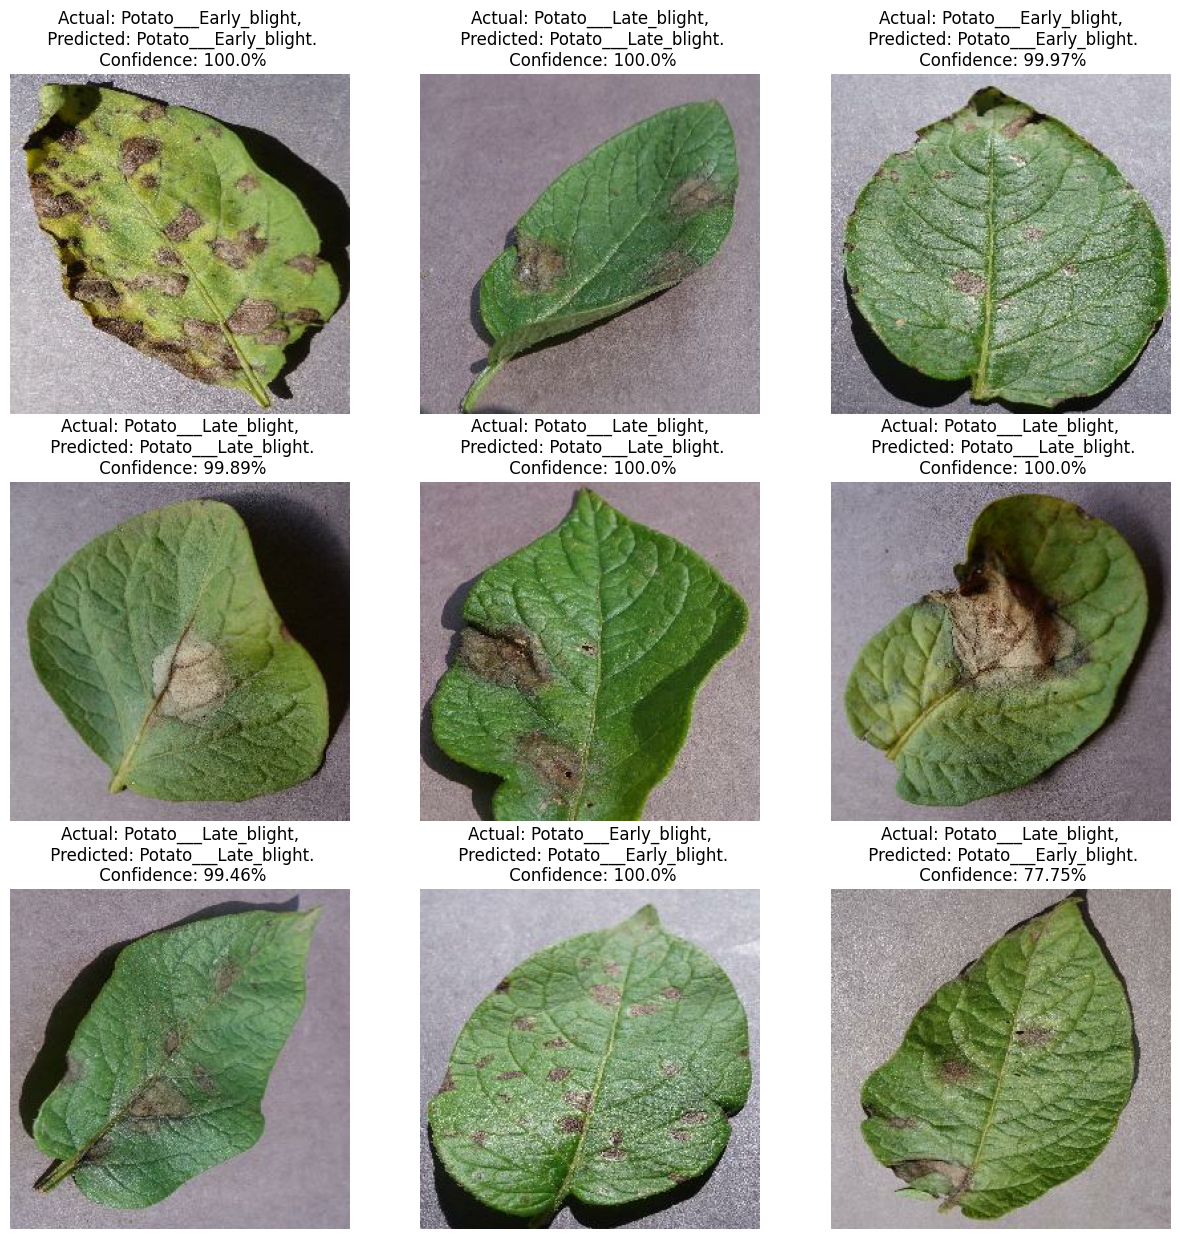

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Save the model

In [36]:
import os

# Specify the directory where you want to save the model
save_dir = "C:/Users/Amit/Desktop/others/Data science/Projects/potato disease prediction"

# List all items in the specified directory
items = os.listdir(save_dir)

# Filter out non-numeric directory names and convert the rest to integers
model_versions = [int(i) for i in items if i.isdigit()]

# If there are no numeric directory names, start with version 1
if not model_versions:
    model_version = 1
else:
    # Increment the highest version number found
    model_version = max(model_versions) + 1

# Create the full path for saving the model
model_save_path = os.path.join(save_dir, str(model_version))

# Save the model
model.save(model_save_path)

print(f"Model saved at: {model_save_path}")


INFO:tensorflow:Assets written to: C:/Users/Amit/Desktop/others/Data science/Projects/Potato disease prediction\3\assets


INFO:tensorflow:Assets written to: C:/Users/Amit/Desktop/others/Data science/Projects/Potato disease prediction\3\assets


Model saved at: C:/Users/Amit/Desktop/others/Data science/Projects/Potato disease prediction\3


In [37]:
# model.save("C:/Users/Amit/Desktop/others/Data science/Projects/Potato disease prediction/Models/..2.h5")

In [38]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.13.0
